### Imports

In [1]:
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors

from pylab import rcParams

rcParams['figure.figsize'] = 6, 5
%matplotlib inline
sns.set_theme(style='white')

# Set random seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Plot function
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

### Combine Review Texts into Single .CSV

In [6]:
address1 = "Data/amazon_cells_labelled.txt"
address2 = "Data/imdb_labelled.txt"
address3 = "Data/yelp_labelled.txt"

df1 = pd.read_csv(address1, delimiter='\t', header=None)
df2 = pd.read_csv(address2, delimiter='\t', header=None)
df3 = pd.read_csv(address3, delimiter='\t', header=None)

df = pd.concat([df1, df2, df3], axis=0)

df.columns = ["Review", "Sentiment"]  # Set column names

#df.to_csv('combined_data.csv', index=False)

df.head()

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


### Read in Data Set
Using the Panda’s library, the file containing the data was read and converted into a Panda’s data frame.

In [8]:
df = pd.read_csv('combined_data.csv')
df.head()

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


### Remove Duplicates and Drop NA Values in Review Text Column
Using methods from the Panda’s data frame, all rows within the ‘Review Text’ column that contained an NA value and rows consisting of duplicate values were dropped from the data frame. Using the length of the data frame as a reference, performing these steps removed 846 rows that contained either NA or duplicate values.

In [3]:
df.info

<bound method DataFrame.info of                                                 Review  Sentiment
0    So there is no way for me to plug it in here i...          0
1                          Good case, Excellent value.          1
2                               Great for the jawbone.          1
3    Tied to charger for conversations lasting more...          0
4                                    The mic is great.          1
..                                                 ...        ...
995  I think food should have flavor and texture an...          0
996                           Appetite instantly gone.          0
997  Overall I was not impressed and would not go b...          0
998  The whole experience was underwhelming, and I ...          0
999  Then, as if I hadn't wasted enough of my life ...          0

[2748 rows x 2 columns]>

In [4]:
len(df)

2748

In [5]:
df.dropna(subset=['Review'], inplace=True)
df.drop_duplicates(inplace=True)

df = df.reset_index(drop=True)

len(df)

2731

### Exploratory Analysis
#### Descriptive Statistics
A table of descriptive statistics such as the count, mean, and standard deviation of all numerical variables was created using the data frame method 'describe'. This table provides insights into the distribution of the samples by providing information about the ages of the customers and how they feel about the products and services offered by the company through variables such as Rating, Recommended IND, and positive feedback count.

In [6]:
df.describe().astype(int)

,Sentiment
count,2731
mean,0
std,0
min,0
25%,0
50%,1
75%,1
max,1


#### Visualizing the Data with Count Plot
A count plot was created for the Sentiment variable. These count plots show the distribution by class and help visualize the class imbalance that will need to be handled during the analysis.

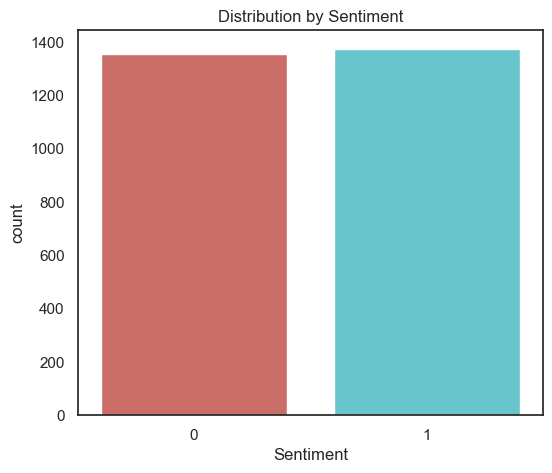

In [7]:
sns.countplot(x='Sentiment', data=df, palette='hls')
plt.title('Distribution by Sentiment')
plt.show()

In [8]:
df['Sentiment'].value_counts()

Sentiment
1    1376
0    1355
Name: count, dtype: int64

### Verify No Null Values Remain
To ensure that all null values that were present at the beginning of the analysis were now either imputed or dropped, the ‘isnull()’ method was used on the data frame. Upon viewing the output, no null values remain within the data set and further preprocessing can continue.

In [9]:
df.isnull().sum()

Review       0
Sentiment    0
dtype: int64

### Clean Reviews
Reviews Prior to Preprocessing

In [10]:
df['Review']

0       So there is no way for me to plug it in here i...
1                             Good case, Excellent value.
2                                  Great for the jawbone.
3       Tied to charger for conversations lasting more...
4                                       The mic is great.
                              ...                        
2726    I think food should have flavor and texture an...
2727                             Appetite instantly gone.
2728    Overall I was not impressed and would not go b...
2729    The whole experience was underwhelming, and I ...
2730    Then, as if I hadn't wasted enough of my life ...
Name: Review, Length: 2731, dtype: object

### Clean and Tokenize Reviews
Performing text preprocessing is an essential part of NLP. Well-known tools from the NLTK library were used to create a custom function that performed all necessary text processing.
In the function, reviews are converted to all lowercase letters and then tokenized into individual word tokens. Those tokens are then lemmatized, stop words are removed, and only words containing alphabetic characters are retained. Finally, from the cleaned tokens, only unique tokens greater than two letters in length are kept in each review.

In [11]:
# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def clean_reviews(text):
    tokens = word_tokenize(text.lower())
    stop_words = nltk.corpus.stopwords.words('english')
    lemmas = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    clean_text = [word for word in lemmas if word.isalpha() and not word in stop_words]
    
    unique_tokens = set([word for word in clean_text if len(word) > 2])
    cleaned_text = ' '.join(unique_tokens)
    
    return unique_tokens, cleaned_text

df[['tokenized_review', 'cleaned_review']] = df['Review'].apply(clean_reviews).apply(pd.Series)

# Calculate the vocab_size
vocabulary = set()
for tokens in df['tokenized_review']:
    vocabulary.update(tokens)
vocab_size = len(vocabulary)

df.head()

,Review,Sentiment,tokenized_review,cleaned_review
0,So there is no way for me to plug it in here i...,0,"{converter, plug, way, unless}",converter plug way unless
1,"Good case, Excellent value.",1,"{excellent, good, value, case}",excellent good value case
2,Great for the jawbone.,1,"{jawbone, great}",jawbone great
3,Tied to charger for conversations lasting more...,0,"{lasting, conversation, charger, problem, tied}",lasting conversation charger problem tied
4,The mic is great.,1,"{great, mic}",great mic


### Calculate Number of Words per Review
While not necessary to know the number of words in each review when performing the logistic regression, it is a requirement of the neural network to set a maximum length. It is also good to explore this aspect of the reviews to get a better sense of how the reviews play a part in the sentiment analysis.

Using the data frame’s built-in apply function and a custom function designed to split each review by spaces (thus separating each word) and then calculating the length of each word,  a new column containing the word count for each review was added to the data frame.

In [12]:
# Function that returns number of tokens in set
def token_count(token_set):
    # Return length of token set
    return len(token_set)

# Create num_tokens feature in df
df['num_tokens'] = df['tokenized_review'].apply(token_count)

df.head()

,Review,Sentiment,tokenized_review,cleaned_review,num_tokens
0,So there is no way for me to plug it in here i...,0,"{converter, plug, way, unless}",converter plug way unless,4
1,"Good case, Excellent value.",1,"{excellent, good, value, case}",excellent good value case,4
2,Great for the jawbone.,1,"{jawbone, great}",jawbone great,2
3,Tied to charger for conversations lasting more...,0,"{lasting, conversation, charger, problem, tied}",lasting conversation charger problem tied,5
4,The mic is great.,1,"{great, mic}",great mic,2


### Exploring Review Lengths
The longest and shortest reviews are calculated below as well as the average review length, the standard deviation of the review lengths, and the median review length.

In [13]:
print('The longest review is', max(df['num_tokens']), 'tokens.')
print('The shortest review is', min(df['num_tokens']), 'tokens.')
print('The average review is', round(np.mean(df['num_tokens'])), 'tokens.')
print('The standard deviation of the token count is', round(np.std(df['num_tokens'])), 'tokens.')
print('The median review length has', round(np.median(df['num_tokens'])), 'tokens.')

The longest review is 447 tokens.
The shortest review is 0 tokens.
The average review is 6 tokens.
The standard deviation of the token count is 12 tokens.
The median review length has 5 tokens.


In [14]:
len(df)

2731

### Visualizing Review Length Distribution
A count plot of the number of words per review was created to get a visual representation of the composition of review lengths. The longest review is 54 words in length and to better preserve the reviews, this is selected as the maximum sequence length for the neural network.

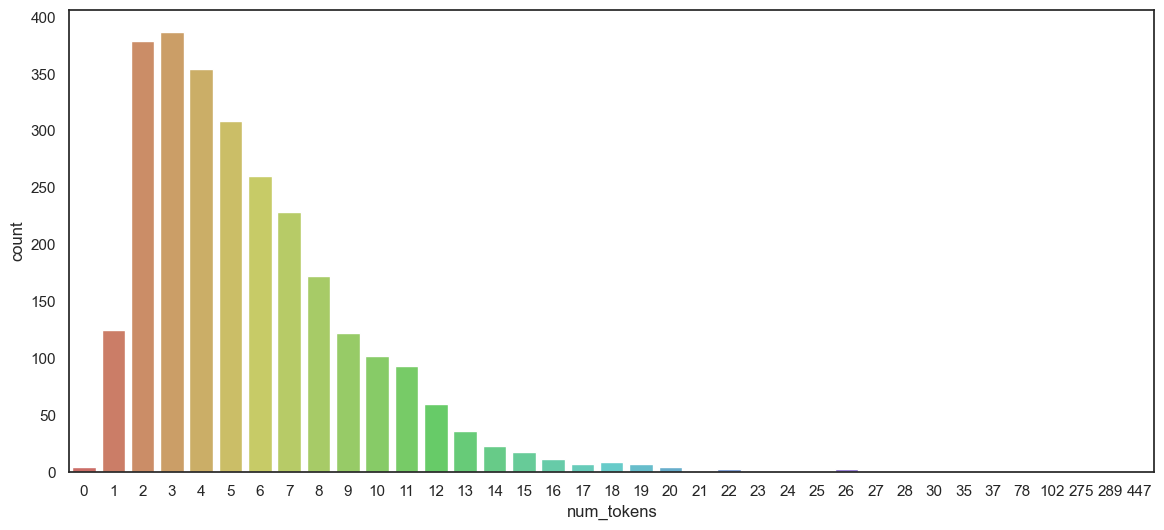

In [15]:
sns.set(rc={'figure.figsize':(14, 6)}, style='white')
sns.countplot(x = df['num_tokens'], palette='hls');

### Train Word2Vec Model on Tokenized Reviews
To run the logistic regression, it was necessary to convert the words from each review into a numerical representation. 

In [16]:
# Load the pre-trained FastText model with the correct encoding
word2vec_model = KeyedVectors.load_word2vec_format('wiki.en.vec')

In [17]:
# Create empty lists to store the review embeddings
review_embeddings = []

# Iterate over tokenized reviews
for review_tokens in df['tokenized_review']:
    # Initialize an empty review embedding
    review_embedding = np.zeros(word2vec_model.vector_size)
    
    # Iterate over tokens in the review
    for token in review_tokens:
        # Check if the token exists in the FastText vocabulary
        if token in word2vec_model:
            # Add the token's embedding to the review embedding
            review_embedding += word2vec_model[token]
    
    # Append the review embedding to the list
    review_embeddings.append(review_embedding)

### Split the Data for Logistic Regression
The data is split into 80% training and 20% testing sets using the vectorized reviews as X and the labeled Recommended IND variable as y. The data is set to stratify so that both training and testing sets have similar proportions of each label and the data is shuffled.

In [18]:
# Assign the target variable
y = df['Sentiment']
X = review_embeddings

# Create Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y,
                                                   shuffle=True)

### Random Forest Regression with Cross-Validation

In [19]:
# Instantiate RF 
rf = RandomForestRegressor(random_state=42)

# Define hyperparams
params_rf = {
             'n_estimators':[400,600,800],
             'max_depth':[5,7,9],
             'min_samples_leaf':[1,2,3],
             'max_features':['sqrt',0.5,0.9]
            }

# Instantiate grid search object 'grid_rf'
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       cv=3,
                       scoring='neg_mean_squared_error',
                       verbose=1,
                       n_jobs=6)
# Fit 'grid_rf' to training data
grid_rf.fit(X_train, y_train)

# Extract best hyperparams from 'grid_rf'
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

# Extract best model from 'grid_rf'
best_model = grid_rf.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# Apply threshold to convert continuous predicted values to binary predictions
threshold = 0.5
y_pred_binary = [1 if val > threshold else 0 for val in y_pred]

# Evaluate RMSE
mse_test = MSE(y_test, y_pred)
rmse_test = mse_test**(1/2)
print()
print('Test set RMSE: {:.2f}'.format(rmse_test))
print('Test set MSE: {:.2f}'.format(mse_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best hyperparameters:
 {'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 3, 'n_estimators': 800}

Test set RMSE: 0.41
Test set MSE: 0.17


In [20]:
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print('Accuracy score on test data: {:.2f}'.format(accuracy))
print('Precision score on test data: {:.2f}'.format(precision))
print('Recall score on test data: {:.2f}'.format(recall))
print('F1-score on test data: {:.2f}'.format(f1))

Accuracy score on test data: 0.77
Precision score on test data: 0.74
Recall score on test data: 0.83
F1-score on test data: 0.78


### Random Forest Regression Classification Report

In [21]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       271
           1       0.74      0.83      0.78       276

    accuracy                           0.77       547
   macro avg       0.77      0.77      0.77       547
weighted avg       0.77      0.77      0.77       547



### Random Forest Confusion Matrix Heatmap

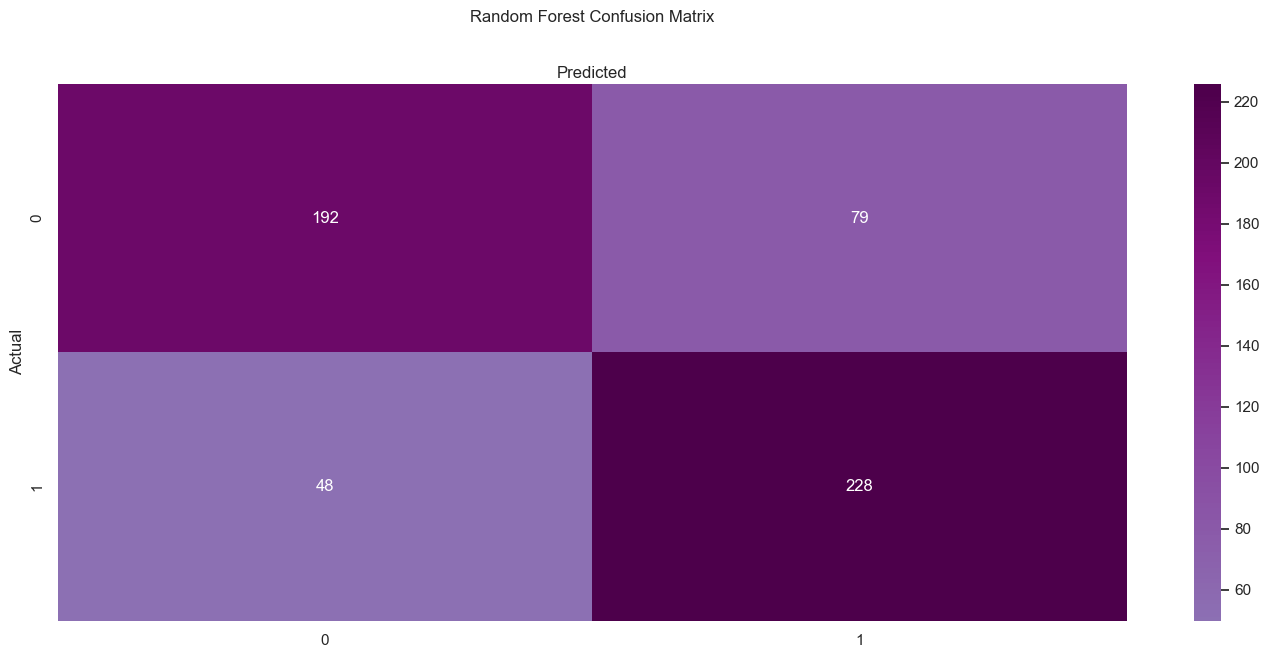

In [22]:
# Calculate the confusion matrix
rf_confusion_matrix = confusion_matrix(y_test, y_pred_binary)

class_names = ['0', '1']

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create the heatmap
sns.heatmap(pd.DataFrame(rf_confusion_matrix), annot=True, cmap='BuPu', fmt='g', robust=True, center=0,
            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Random Forest Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Logistic Regression with Cross-Validation
The logistic regression is run using the 'LogisticRegressionCV' method from sklearn. The logistic regression uses the 'sag', or stochastic average gradient, solver as it converges more quickly with larger data sets and the calculated class weights are applied to help the algorithm learn both classes more efficiently. In addition to that, the C and l1_ratios parameters are tuned using a stratified 5-fold cross-validation, optimum selection based upon accuracy scores (Pedregosa et al., 2011). Max iterations increased to 300 to assist with convergence as well. The accuracy of the logistic regression using the training data is 94.41%.

In [23]:
# Train a logistic regression model with cross-validation
log_reg = LogisticRegressionCV(random_state=42, n_jobs=6, solver='liblinear', cv=5).fit(X_train, y_train)

# Predict the labels for the training data
y_pred = log_reg.predict(X_test)

# Apply threshold to convert continuous predicted values to binary predictions
threshold = 0.5
y_pred_binary = [1 if val > threshold else 0 for val in y_pred]

# Calculate the accuracy on the test data
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the accuracy on the test data
print('Accuracy score on test data: {:.2f}'.format(accuracy))
print('Precision score on test data: {:.2f}'.format(precision))
print('Recall score on test data: {:.2f}'.format(recall))
print('F1-score on test data: {:.2f}'.format(f1))

Accuracy score on test data: 0.81
Precision score on test data: 0.80
Recall score on test data: 0.82
F1-score on test data: 0.81


### Predict on Testing Data
Using the optimized logistic regression, predictions are made using the testing data set. This is done to check how well the model can generalize on unseen data. This model predicted labels for the testing data set with 89.47% accuracy.

### Logistic Regression Classification Report
The true performance of a model is seen when checking the predicted labels against the true labels as this indicates the true accuracy of the model to predict on new data. The F1-score is described as "...the harmonic mean of the model’s precision and recall" (Wood, 2019). As seen in the classification report table below, the F1-score for label 0 is 74% with a total of 820 samples and the F1-score for label 1 is 93% with a total of 3708 samples. 

It is not surprising that there is a discrepancy of almost 20% between the two classes as this data set is highly imbalanced. While the class weights applied to the algorithm do improve performance of the smaller class, it is not sufficient to totally overcome the issues associated with the imbalance. The impact of the class weights can be seen more dramatically in the recall, which is the proportion of actual positives that were correctly identified (Google, n.d.). The recall here shows a score of 83% for label 0 and 91% for label 1 indicating that the algorithm was similarly sensitive to both classes.

Due to the imbalanced classes, it is better to consider the macro average F1-score as it treats both classes equally as both classes are equally important in this classification model (Leung, 2022). The macro F1-score for this model is 84%.

In [24]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       271
           1       0.80      0.82      0.81       276

    accuracy                           0.81       547
   macro avg       0.81      0.81      0.81       547
weighted avg       0.81      0.81      0.81       547



### Logistic Regression Confusion Matrix Heatmap
Using sklearn's confusion matrix and seaborn, a confusion matrix was created based upon the logistic regression results. This confusion matrix is a visual representation of the actual versus predicted counts by label. The true positives can be seen on the diagonal with label Not Recommended (0) having 682 correct predictions and label Recommended (1) with 3369 correct predictions. The other numbers represent false positives and false negatives for both classes.

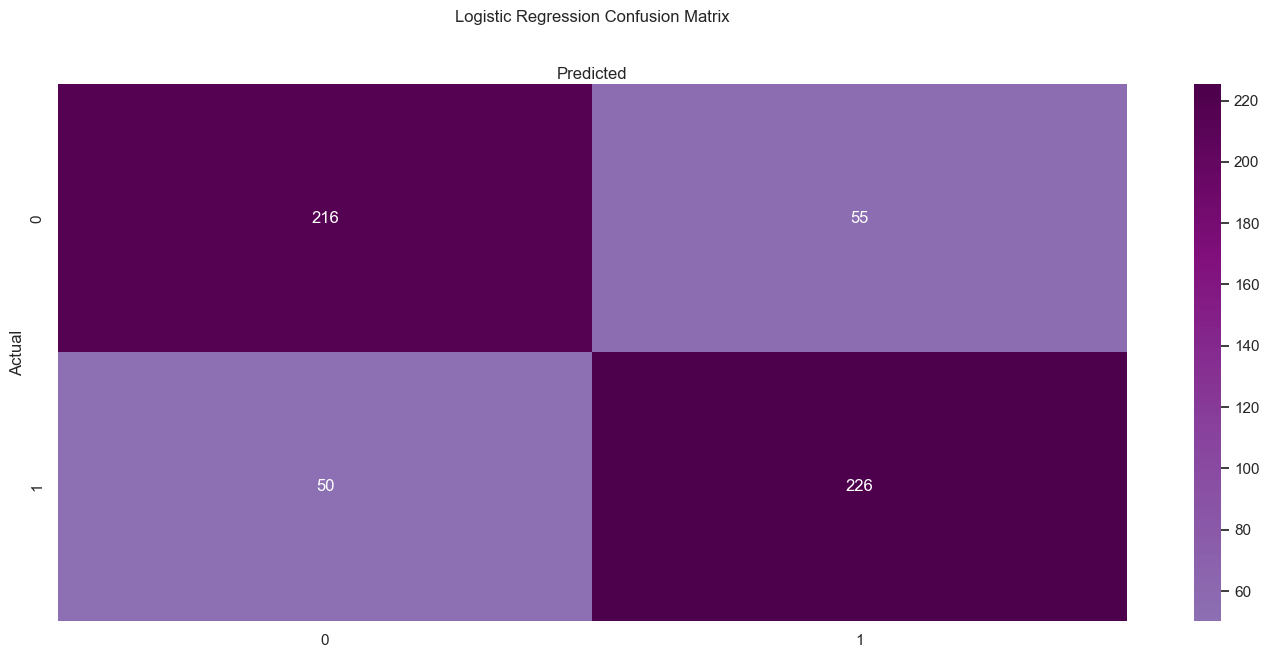

In [25]:
# Calculate the confusion matrix
lr_confusion_matrix = confusion_matrix(y_test, y_pred_binary)

class_names = ['0', '1']

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create the heatmap
sns.heatmap(pd.DataFrame(lr_confusion_matrix), annot=True, cmap='BuPu', fmt='g', robust=True, center=0,
            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Logistic Regression Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Preprocessing with TensorFlow
TensorFlow was chosen as the platform for the neural network because of its extensive tools and libraries that allow for both the preprocessing aspects of the neural network as well as building the model (TensorFlow, n.d.). 

In order for the reviews to be run through the CNN-LSTM neural network, the cleaned reviews were tokenized, converted to sequences of numbers, and then padded to a maximum length of 54 so that all reviews were the same length. This process separates each word of the review into individual tokens and then converts them to numerical representations that the model can then use. A maximum length of 54 was chosen as it is the length of the longest review in an effort to preserve all data within the reviews.

In [26]:
max_sequence_length = 42

tokenizer = Tokenizer()

tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post', padding='post')

In [27]:
padded_sequences[0]

array([1902,  220,   40,  505,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

### Split the Data for CNN-LSTM
The data is again split into 80% training and 20% testing sets this time using the padded sequences for X and again the labeled ‘Recommended IND’ variable as y. The data is set to stratify so that both training and testing sets have similar proportions for each label and the data is shuffled.

In [28]:
# Assign the target variable
y = df['Sentiment']
X = padded_sequences


# Create Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y,
                                                   shuffle=True)

### Create Callbacks
Callbacks can be created to do a variety of functions. For this model, an EarlyStopping callback is created to tell the model to stop training if the validation loss stops improving and to restore the model to the best weights achieved. Using this callback is a way to keep the model from overfitting.

### CNN-LSTM Model

### Build CNN-LSTM Model
Using a Sequential model, layers are added starting with an embedding layer. The embedding layer sets the word embeddings for the model, dictated by vocabulary size and maximum review length.

Following the embedding layer, a series of one-dimensional convolution, batch normalization, and max pooling layers are added. These are followed by a dropout layer, two LSTM layers each followed by a batch normalization layer, a dense layer followed by a final batch normalization layer, and the final dense output layer. 

All of the activation functions are set to 'leaky_relu' with the exception of the final dense layer which is 'sigmoid' so the model can output predictions. This activation was chosen as it had superior results based on experimentation.

The model is compiled using the 'Adam' optimizer with a learning rate of 1e-5 and the binary crossentropy loss function.

'Adam', a stochastic gradient descent optimizer, was selected for its efficient reliablity when dealing with a large number of parameters (Abadi et al., 2015).

The binary crossentropy loss function was selected for this model because of its optimal performance with binary classification models (Introduction to Deep Learning with Keras).

In [29]:
max_sequence_length = 42
vocab_size = len(tokenizer.word_index) + 1 # Add 1 for the unknown token
embedding_dim = word2vec_model.vector_size

address = "CNN-LSTM-Model"


# Establish callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
modelCheckpoint = ModelCheckpoint('best_model.hdf5', save_best_only = True)


def create_embedding_matrix(word2vec_model, tokenizer):
    embedding_dim = word2vec_model.vector_size
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word2vec_model, tokenizer)

def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_sequence_length,
            trainable=False,
            weights=[embedding_matrix]
        ),
        tf.keras.layers.Conv1D(
            hp.Int('conv1d', min_value=32, max_value=512, step=32),
            kernel_size=3,
            activation=hp.Choice('activation1', ['relu', 'sigmoid'])
        ),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.LSTM(
            hp.Int('lstm', min_value=32, max_value=512, step=32),
            dropout=hp.Choice('dropout', [.0, .2, .4, .6])
        ),
        tf.keras.layers.Dense(
            hp.Int('dense1', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation2', ['relu', 'sigmoid'])
        ),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('opt',[1e-2,1e-3,1e-4])),
                  metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        overwrite=True,
        directory=address,
        project_name="sentiment_model")

tuner.search(X_train, y_train, epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks = [early_stopping, modelCheckpoint],
                    verbose=2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal parameters are:
Conv1D layer: {best_hps.get('conv1d')}
Activation function 1: {best_hps.get('activation1')}
LSTM layer: {best_hps.get('lstm')}
Dropout rate: {best_hps.get('dropout')}
Dense layer 1: {best_hps.get('dense1')}
Activation function 2: {best_hps.get('activation2')}
Learning rate for the optimizer: {best_hps.get('opt')}
""")

Trial 10 Complete [00h 00m 30s]
val_loss: 0.4301881790161133

Best val_loss So Far: 0.4255935251712799
Total elapsed time: 00h 06m 03s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal parameters are:
Conv1D layer: 128
Activation function 1: relu
LSTM layer: 160
Dropout rate: 0.6
Dense layer 1: 512
Activation function 2: sigmoid
Learning rate for the optimizer: 0.0001



### Model Summary
The model summary shows the output shape and the number of parameters for each layer.

The model consists of:
- Total params: 1,703,833
- Trainable params: 383,233
- Non-trainable params: 1,320,600

In [30]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 42, 300)           1320600   
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           115328    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 20, 128)           0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 160)               184960    
                                                                 
 dense_2 (Dense)             (None, 512)               82432     
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                      

### Train the Model
The model is trained using the training set, a batch size of 25, 100 epochs but utilizing the EarlyStopping callback, the testing set is used for the validation data, and the calculated class weights are applied. 

The training stopped at epoch 29 and the model reset the weights to be best epoch which was epcoh 19.

In [31]:
# Build model with optimal hyperparams and train it on the data
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks = [early_stopping, modelCheckpoint],
                    verbose=2)

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
69/69 - 3s - loss: 0.6950 - accuracy: 0.4945 - val_loss: 0.6930 - val_accuracy: 0.5046 - 3s/epoch - 41ms/step
Epoch 2/100
69/69 - 1s - loss: 0.6852 - accuracy: 0.5229 - val_loss: 0.6111 - val_accuracy: 0.7221 - 1s/epoch - 17ms/step
Epoch 3/100
69/69 - 1s - loss: 0.5461 - accuracy: 0.7262 - val_loss: 0.4758 - val_accuracy: 0.7989 - 1s/epoch - 17ms/step
Epoch 4/100
69/69 - 1s - loss: 0.4906 - accuracy: 0.7775 - val_loss: 0.4639 - val_accuracy: 0.8007 - 1s/epoch - 17ms/step
Epoch 5/100
69/69 - 1s - loss: 0.4320 - accuracy: 0.8072 - val_loss: 0.4344 - val_accuracy: 0.8062 - 1s/epoch - 17ms/step
Epoch 6/100
69/69 - 1s - loss: 0.4132 - accuracy: 0.8150 - val_loss: 0.4303 - val_accuracy: 0.8135 - 1s/epoch - 17ms/step
Epoch 7/100
69/69 - 1s - loss: 0.3925 - accuracy: 0.8292 - val_loss: 0.4269 - val_accuracy: 0.8135 - 1s/epoch - 17ms/step
Epoch 8/100
69/69 - 1s - loss: 0.3632 - accuracy: 0.8553 - val_loss: 0.4360 - val_accuracy: 0.8135 - 1s/epoch - 16ms/step
Epoch 9/100
69/69 - 1s -

### Retrain Model with Best Epoch

In [32]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch,
                validation_data=(X_test, y_test),
                callbacks = [early_stopping, modelCheckpoint],
                verbose=2)

Epoch 1/7
69/69 - 3s - loss: 0.6972 - accuracy: 0.4986 - val_loss: 0.6922 - val_accuracy: 0.5046 - 3s/epoch - 40ms/step
Epoch 2/7
69/69 - 1s - loss: 0.6869 - accuracy: 0.5169 - val_loss: 0.6496 - val_accuracy: 0.7294 - 1s/epoch - 17ms/step
Epoch 3/7
69/69 - 1s - loss: 0.5586 - accuracy: 0.7207 - val_loss: 0.4767 - val_accuracy: 0.7916 - 1s/epoch - 17ms/step
Epoch 4/7
69/69 - 1s - loss: 0.4692 - accuracy: 0.7839 - val_loss: 0.4493 - val_accuracy: 0.8044 - 1s/epoch - 17ms/step
Epoch 5/7
69/69 - 1s - loss: 0.4359 - accuracy: 0.8072 - val_loss: 0.4393 - val_accuracy: 0.8099 - 1s/epoch - 17ms/step
Epoch 6/7
69/69 - 1s - loss: 0.4166 - accuracy: 0.8210 - val_loss: 0.4325 - val_accuracy: 0.8117 - 1s/epoch - 16ms/step
Epoch 7/7
69/69 - 1s - loss: 0.3779 - accuracy: 0.8416 - val_loss: 0.4297 - val_accuracy: 0.8172 - 1s/epoch - 17ms/step


### Calculate Accuracy and Loss
Using the testing portion of the data, the model is evaluated and the loss and accuracy are calculated. The loss is 31.59% and the accuracy is 89.44%.

In [33]:
test_loss, test_acc = hypermodel.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

18/18 [==============================] - 0s 6ms/step - loss: 0.4297 - accuracy: 0.8172
Test Loss: 0.42967379093170166
Test Accuracy: 0.8171846270561218


### Accuracy and Loss Plots
Two plots were generated, an accuracy and a loss plot. The accuracy plot compares the training and validation accuracy across epochs. The loss plot compares the training and validation loss across epochs.

(0.0, 0.7132048413157464)

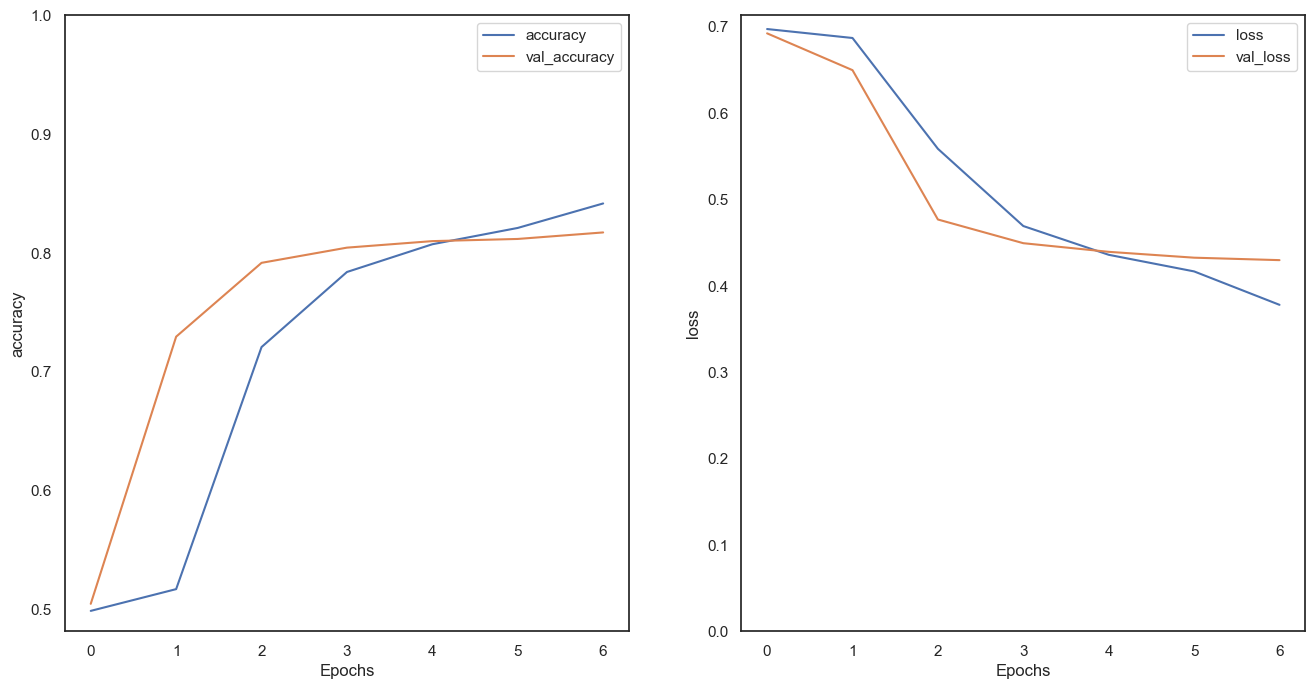

In [34]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### CNN-LSTM Classification Report
In order to compare this model with the logistic regression, a classification report was also run on the results from the CNN-LSTM model. The F1-score for label 0 is 71% with 820 samples and the F1-score for label 1 is 93% with 3708 samples. The macro F1-score for this model is 82%.

In [35]:
# Extract predicted probabilities from neural network
p_pred = model.predict(X_test)
p_pred = p_pred.flatten()

# Extract predicted class labels
p = 0.5
y_pred = p_pred > p

print(classification_report(y_test, y_pred))

18/18 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       271
           1       0.83      0.82      0.82       276

    accuracy                           0.82       547
   macro avg       0.82      0.82      0.82       547
weighted avg       0.82      0.82      0.82       547



### CNN-LSTM Confusion Matrix
A confusion matrix was created for the CNN-LSTM model using the same techniques as with the logistic regression model.

The true positives can be seen on the diagonal with label Not Recommended (0) having 619 correct predictions and label Recommended (1) with 3391 correct predictions. Again, the other numbers represent false positives and false negatives for both classes.

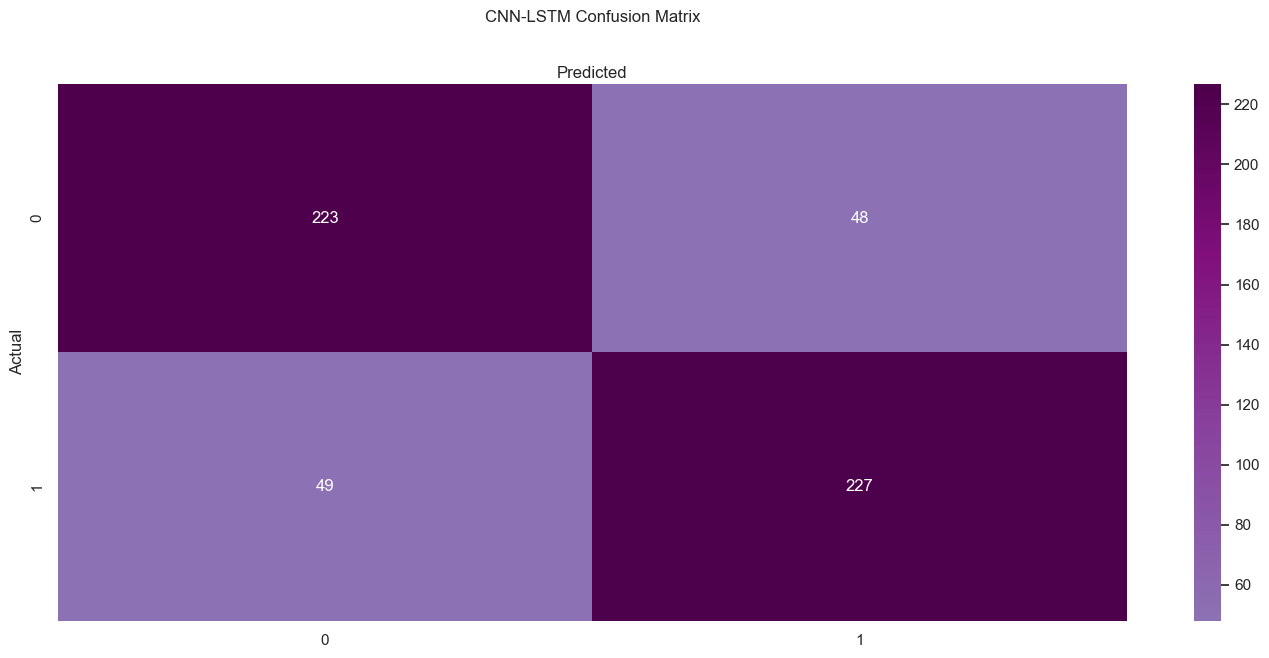

In [36]:
nn_confusion_matrix = confusion_matrix(y_test, y_pred)

class_names=["0", "1"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(nn_confusion_matrix), annot=True, cmap="BuPu" ,fmt='g', robust=True, center=0,
           xticklabels=["0", "1"], yticklabels=['0', '1'])
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('CNN-LSTM Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted');

### Summary and Implications
The results of the data analysis show that the logistic regression model is better able to predict customer sentiment from the online customer reviews. The table below highlights the accuracy of both models:
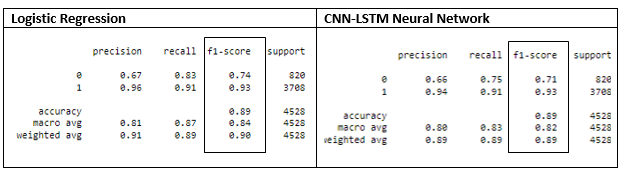
The F1-scores indicate that the logistic regression has a macro average of 84% while the CNN-LSTM neural network was only able to achieve a macro average of 83%. Looking at the accuracy of the labels separately, both models were able to predict on label 1 for an F1-score of 93% but the neural network struggled with recall for label 0 and as such could only achieve an F1-score of 72%.

One limitation of this analysis is that the classes were imbalanced and despite the application of class weights to the models, the classification reports clearly show that the effects of the imbalance were still present even though these results were improved above baseline models without weights applied.

Based on these results, the clothing company should utilize the logistic regression model to monitor customer reviews as it can successfully analyze customer sentiment on new online reviews with 84% accuracy. This will allow the company to quickly identify potential issues such as the loss of consumer support and improve the products and services they offer to capitalize on these positive customer experiences (Kumar, 2021).

Suggestions for future study are:
•	Use an ensemble classification method such as random forest to enhance accuracy and limit impact of class imbalance
•	Use a different variable for the sentiment labels such as Rating that might more accurately capture customer sentiment